In this problem, you are going to implement the A* algorithm from scratch to find the shortest path between two locations in California's road network from the United States Census Bureau. 

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, andfunctions of complex networks.   https://networkx.org/

You need Smopy for this problem. You can install it with 

pip install git+https://github.com/rossant/smopy. 

In order for NetworkX to read Shapefile datasets, you also need GDAL/OGR. You can install it with 

conda install gdal

In [2]:
import io
import zipfile
import requests
import networkx as nx
import numpy as np
import pandas as pd
import json
! pip install smopy
import smopy
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We load the data (a Shapefile dataset) with NetworkX. This dataset contains detailed information about the primary roads in California. NetworkX's read_shp() function returns a graph, where each node is a geographical position, and each edge contains information about the road linking the two nodes.

In [3]:
url = ('https://github.com/ipython-books/'
       'cookbook-2nd-data/blob/master/'
       'road.zip?raw=true')
r = io.BytesIO(requests.get(url).content)
zipfile.ZipFile(r).extractall('data')
g = nx.read_shp('data/tl_2013_06_prisecroads.shp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  


In [4]:
g

This graph is not necessarily connected, but we need a connected graph in order to compute shortest paths. Here, we take the largest connected subgraph. 

In [5]:
#sgs = list(nx.connected_component_subgraphs(g.to_undirected()))

from networkx import subgraph, connected_components
sgs = list(g.to_undirected().subgraph(c) for c in connected_components(g.to_undirected()))

i = np.argmax([len(sg) for sg in sgs])
sg = sgs[i]
len(sg)

464

We define two positions (with the latitude and longitude) and find the shortest path between these two positions:

In [6]:
pos0 = (37.6026, -121.9926)
pos1 = (34.0569, -118.2427)

Each edge in the graph contains information about the road, including a list of points along this road. We first create a function that returns this array of coordinates, for any edge in the graph:

In [7]:
def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph,
    this function returns an array of point
    coordinates along the road linking these two
    nodes."""
    return np.array(json.loads(sg[n0][n1]['Json'])
                    ['coordinates'])

We can notably use the road path to compute its length. We first need to define a function that computes the distance between any two points in geographical coordinates:

In [8]:
# from [https://stackoverflow.com/a/8859667/1595060](https://stackoverflow.com/a/8859667/1595060)
EARTH_R = 6372.8

def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points
    in geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
        (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
         np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

Now, we define a function computing a path's length:

In [9]:
def get_path_length(path):
    return np.sum(geocalc(path[1:, 1], path[1:, 0],
                          path[:-1, 1], path[:-1, 0]))


We update our graph by computing the distance between any two connected nodes. We add this information with the distance attribute of the edges:

In [17]:
# Compute the length of the road segments.
for n0, n1 in sg.edges:
    path = get_path(n0, n1)
    distance = get_path_length(path)
    sg.edges[n0, n1]['distance'] = distance

The last step before we can find the shortest path in the graph is to find the two nodes in the graph that are closest to the two requested positions:

In [30]:
nodes = np.array(sg.nodes())
# Get the closest nodes in the graph.
pos0_i = np.argmin(
    np.sum((nodes[:, ::-1] - pos0)**2, axis=1))
pos1_i = np.argmin(
    np.sum((nodes[:, ::-1] - pos1)**2, axis=1))


In [51]:
# taking start and goal which are closest to the given co-ordinates pos0 and pos1 from the sg.nodes
start=(nodes[pos0_i][0],nodes[pos0_i][1])
goal=(nodes[pos1_i][0],nodes[pos1_i][1])
print(start,goal)

(-121.910796, 36.978296) (-118.252687, 34.06576299999999)


TODO: implement A* algorithm from scratch

In [53]:
# creating PriorityQueue Data Struct 
import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []
    
    def empty(self) -> bool:
        return not self.elements
    
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
    
    def get(self):
        return heapq.heappop(self.elements)[1]




# to construct path 
def reconstruct_path(came_from, start, goal):

    current= goal
    path = []
    while current != start: 
        path.append(current)
        current = came_from[current]
    path.append(start)
    path.reverse() 
    return path

#TODO implement A* algorithm from scratch
def astar_path(graph, start, goal):
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from= {}
    cost_so_far= {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():   # bfs
        current = frontier.get()
        
        if current == goal:
            break
        
        for next in graph.neighbors(current):
            new_cost = cost_so_far[current] + sg.edges[current, next]['distance']
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(next, goal)
                frontier.put(next, priority)
                came_from[next] = current    
            
    return reconstruct_path(came_from, start, goal)



TODO: use A* algorithm to find the shortest path. Once the itinerary has been computed, the path variable should contain the list of edges that form the shortest path between our two positions.

In [56]:

#Please define your heuristic and explain why
import math


def heuristic(a, b):
    (x1, y1) = a
    (x2, y2) = b
    dx = abs(x1 - x2)
    dy = abs(y1 - y2)
    return math.sqrt(dx * dx + dy * dy)
  
'''
   why this heuristic?
   Use the distance heuristic that matches the allowed movement:

On a square grid that allows 4 directions of movement, use Manhattan distance. 
On a square grid that allows 8 directions of movement, use Diagonal distance.
On a hexagon grid that allows 6 directions of movement, use Manhattan distance adapted to hexagonal grids.
On a square grid that allows any direction of movement, you might or might not want Euclidean distance .

here I am considering that we can move in any direction on the grid/subgraph. Hence, euclidian distance heuristic fits well.
'''
#TODO use A* algorithm to find the shortest path

path = astar_path(sg, start, goal)
len(path)

24

In [57]:
for i in range(0,len(path)):
  print(i,path[i])

0 (-121.910796, 36.978296)
1 (-121.77227100000002, 36.883852999999995)
2 (-121.77044000000001, 36.87352599999999)
3 (-121.765708, 36.759420999999996)
4 (-121.912731, 36.567796)
5 (-121.345267, 35.795176999999995)
6 (-121.105997, 35.56953599999999)
7 (-121.069062, 35.54903699999999)
8 (-120.968036, 35.46281)
9 (-120.663604, 35.286750999999995)
10 (-120.663466, 35.286594)
11 (-120.667112, 35.28362599999999)
12 (-120.668087, 35.282367)
13 (-120.66803900000001, 35.28244699999999)
14 (-120.696564, 35.206576999999996)
15 (-120.698242, 35.198546)
16 (-120.432905, 34.98512999999999)
17 (-119.47819900000002, 34.37667199999999)
18 (-119.477927, 34.37656299999999)
19 (-118.81457900000001, 34.152454999999996)
20 (-118.377674, 34.154446)
21 (-118.370582, 34.146982)
22 (-118.252773, 34.06582499999999)
23 (-118.252687, 34.06576299999999)


Now, we can get information about the itinerary with pandas. The dataset has a few fields of interest, including the name and type (State, Interstate, and so on) of the roads:

In [58]:
roads = pd.DataFrame(
    [sg.edges[path[i], path[i + 1]]
     for i in range(len(path) - 1)],
    columns=['FULLNAME', 'MTFCC',
             'RTTYP', 'distance'])
roads

,FULLNAME,MTFCC,RTTYP,distance
0,State Rte 1,S1200,S,17.371936
1,Cabrillo Hwy,S1200,M,1.161328
2,State Rte 1,S1200,S,13.957681
3,State Rte 1,S1200,S,26.979412
4,State Rte 1,S1200,S,119.835869
5,State Rte 1,S1200,S,37.559920
6,Cabrillo Hwy,S1200,M,4.412885
7,State Rte 1,S1200,S,13.486984
8,Cabrillo Hwy,S1200,M,37.244017
9,Cabrillo Hwy,S1200,M,0.021492


In [59]:
roads['distance'].sum()

592.619448893457

Finally, let's display the itinerary on the map. We first retrieve the map with Smopy:

In [60]:
m = smopy.Map(pos0, pos1, z=7, margin=.1)

Our path contains connected nodes in the graph. Every edge between two nodes is characterized by a list of points (constituting a part of the road). Therefore, we need to define a function that concatenates the positions along every edge in the path. We have to concatenate the positions in the right order along our path. We choose the order based on the fact that the last point in an edge needs to be close to the first point in the next edge:

In [61]:
def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path) - 1):
        p = get_path(path[i], path[i + 1])
        if curp is None:
            curp = p
        if (np.sum((p[0] - curp) ** 2) >
                np.sum((p[-1] - curp) ** 2)):
            p = p[::-1, :]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

 We convert the path in pixels in order to display it on the Smopy map:

In [62]:
linepath = get_full_path(path)
x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])

Finally, let's display the map, with our two positions and the computed itinerary between them:

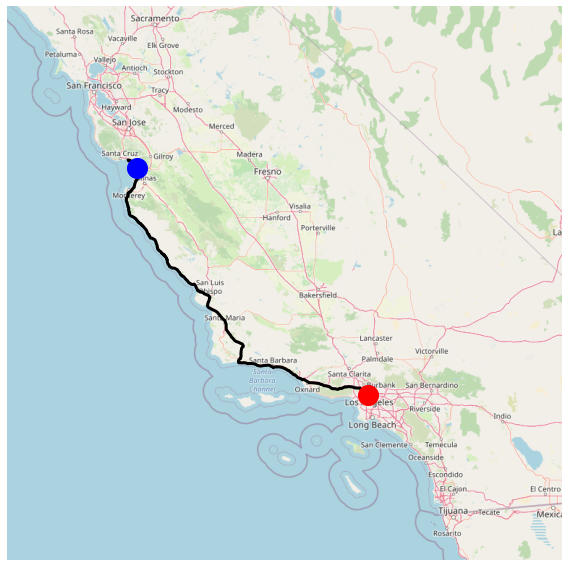

In [63]:
ax = m.show_mpl(figsize=(8, 8))
# Plot the itinerary.
ax.plot(x, y, '-k', lw=3)
# Mark our two positions.
ax.plot(x[0], y[0], 'ob', ms=20)
ax.plot(x[-1], y[-1], 'or', ms=20)